In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('display.max_columns', None)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.15.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('display.max_columns', None)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.15.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('display.max_columns', None)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.15.0


# Extract data

In [4]:
space_titanic_train = pd.read_csv('data/space_titanic_train.csv')
space_titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Explore the data

In [5]:
space_titanic_train.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


<Axes: xlabel='HomePlanet', ylabel='Count'>

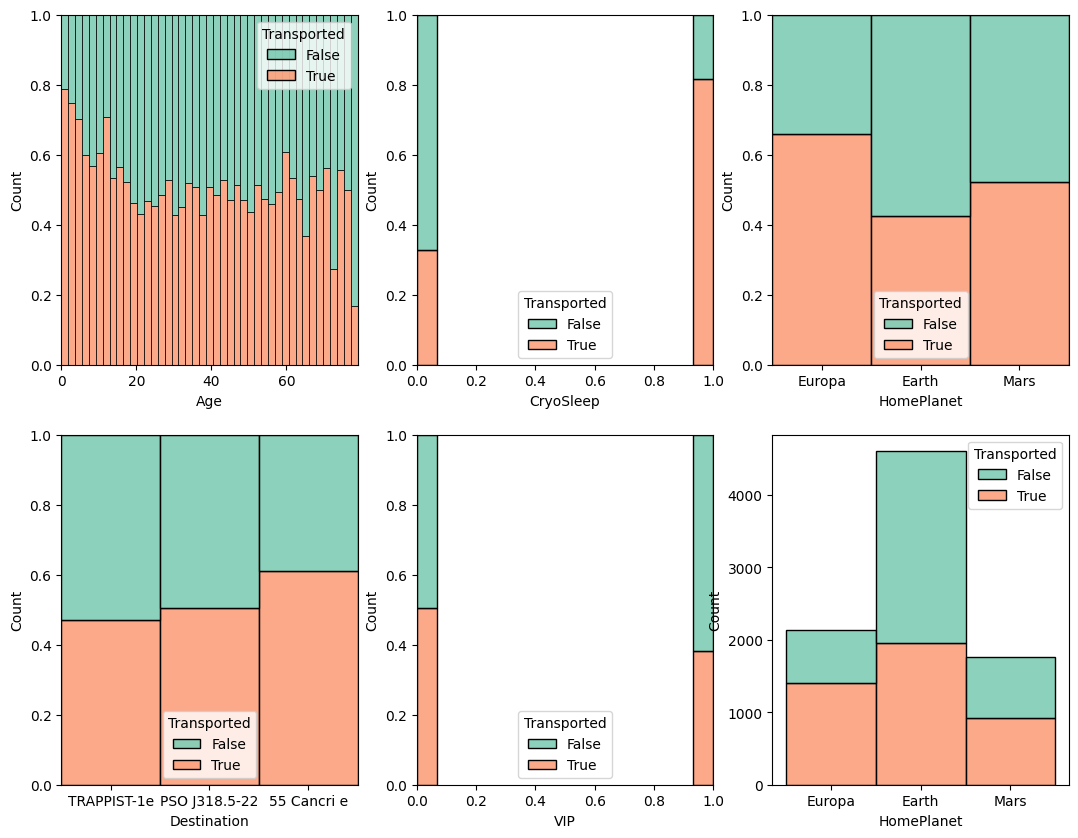

In [6]:
fig, axes = plt.subplots(2,3, figsize=(13, 10))
axes = axes.flatten()


sns.histplot(data = space_titanic_train, x= 'Age', hue='Transported',  multiple='fill', palette='Set2', ax = axes[0])
sns.histplot(data = space_titanic_train, x= 'CryoSleep', hue='Transported',  multiple='fill', palette='Set2', ax = axes[1])
sns.histplot(data = space_titanic_train, x= 'HomePlanet', hue='Transported',  multiple='fill', palette='Set2', ax = axes[2])
sns.histplot(data = space_titanic_train, x= 'Destination', hue='Transported',  multiple='fill', palette='Set2', ax = axes[3])
sns.histplot(data = space_titanic_train, x= 'VIP', hue='Transported',  multiple='fill', palette='Set2', ax = axes[4])
sns.histplot(data = space_titanic_train, x= 'HomePlanet', hue='Transported',  multiple='stack', palette='Set2', ax = axes[5])


# Cleaning and filling missing values

In [7]:
space_titanic_train['VIP'] = space_titanic_train['VIP'].fillna(False)
space_titanic_train['VIP'] = space_titanic_train['VIP'].astype('bool')

space_titanic_train['CryoSleep'] = space_titanic_train['CryoSleep'].fillna(False)

space_titanic_train['Age'] = space_titanic_train['Age'].fillna(space_titanic_train['Age'].mode()[0])


space_titanic_train[['HomePlanet', 'Destination']] = space_titanic_train[['HomePlanet', 'Destination']].fillna('other')
space_titanic_train[['HomePlanet', 'Destination']] = space_titanic_train[['HomePlanet', 'Destination']].astype('string')

space_titanic_train[['cabin_1', 'cabin_2', 'cabin_3']] = space_titanic_train['Cabin'].str.split('/', expand=True)
space_titanic_train[['cabin_1', 'cabin_3']] = space_titanic_train[['cabin_1', 'cabin_3']].fillna('O')

space_titanic_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = space_titanic_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)
space_titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   string 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8494 non-null   object 
 4   Destination   8693 non-null   string 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  cabin_1       8693 non-null   object 
 15  cabin_2       8494 non-null   object 
 16  cabin_3       8693 non-null   object 
dtypes: bool(3), float64(6), object(6), string(2)
memory usage: 976.4+ KB


Potential additional feature engineering:
 - adult/child
 - travel as a family
 - total spend
 - spent anything 1/0

In [8]:
space_titanic_train = space_titanic_train.drop(['PassengerId', 'Name', 'Cabin', 'cabin_2'], axis = 1)
space_titanic_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_1,cabin_3
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S


Create train, test and validation sets

In [9]:
train, test = train_test_split(space_titanic_train, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

5563 train examples
1391 validation examples
1739 test examples


# Create input pipeline

In [10]:
def to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('Transported')
    df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

Visualise a small batch

In [11]:
train_ds = to_dataset(train, batch_size=5)

In [12]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of HomePlanet:', train_features['HomePlanet'])
print('A batch of targets:', label_batch )

Every feature: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'cabin_1', 'cabin_3']
A batch of HomePlanet: tf.Tensor(
[[b'Earth']
 [b'Mars']
 [b'Earth']
 [b'Earth']
 [b'Earth']], shape=(5, 1), dtype=string)
A batch of targets: tf.Tensor([False  True  True  True  True], shape=(5,), dtype=bool)


# Create preprocessing layers

### For numerical features

In [13]:
def get_normalization_layer(name, dataset):
  normalizer = layers.Normalization(axis=None)
  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)
  return normalizer

Let's look a the results for 'ShoppingMall'

In [14]:
shopping_mall = train_features['ShoppingMall']
layer = get_normalization_layer('ShoppingMall', train_ds)
layer(shopping_mall)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.2681932],
       [ 1.165791 ],
       [-0.2681932],
       [-0.2681932],
       [-0.2681932]], dtype=float32)>

### For categorical features

In [15]:
def get_category_encoding_layer(name, dataset, max_tokens=None):
  index = layers.StringLookup(max_tokens=max_tokens)

  feature_ds = dataset.map(lambda x, y: x[name])
  index.adapt(feature_ds)
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  return lambda feature: encoder(index(feature))


Let's look at the results for the column 'HomePlanet'

In [16]:
type_col = train_features['HomePlanet']
layer = get_category_encoding_layer('HomePlanet', train_ds)
layer(type_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [17]:
batch_size = 256
train_ds = to_dataset(train, batch_size=batch_size)
test_ds = to_dataset(test, shuffle=False, batch_size=batch_size)
val_ds = to_dataset(val, shuffle=False, batch_size=batch_size)


In [18]:
numeric_feature_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
other_feature_columns = ['Age', 'CryoSleep', 'VIP']
categ_feature_columns = ['HomePlanet', 'Destination', 'cabin_1', 'cabin_3']

In [19]:
inputs = []
preprocessed = []

In [20]:
for name in numeric_feature_columns:
    numeric_column = tf.keras.Input(shape=(1,), name=name)
    norm_layer = get_normalization_layer(name, train_ds)
    encoded_numeric_column = norm_layer(numeric_column)
    inputs.append(numeric_column)
    preprocessed.append(encoded_numeric_column)

In [21]:
for name in categ_feature_columns:
    categ_column = tf.keras.Input(shape=(1,), dtype='string', name=name)
    categ_layer = get_category_encoding_layer(name, train_ds)
    encoded_categ_column = categ_layer(categ_column)
    inputs.append(categ_column)
    preprocessed.append(encoded_categ_column)

In [22]:
for name in other_feature_columns:
    col = tf.keras.Input(shape=(1,), dtype='float32', name=name)
    
    inputs.append(col)
    
    preprocessed.append(col)

Let's look at 'inputs' and 'preprocessed' lists before and after preprocessing

In [23]:
inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'RoomService')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'FoodCourt')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ShoppingMall')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Spa')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VRDeck')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'HomePlanet')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Destination')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'cabin_1')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'cabin_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Age')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'CryoSleep')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VIP')>]

In [24]:
preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_5')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Age')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'CryoSleep')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VIP')>]

### Create, compile and train the model

In [25]:
all_features = tf.keras.layers.concatenate(preprocessed)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 HomePlanet (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Destination (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 cabin_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 cabin_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

In [27]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/Users/claireschultzberg/Repository/ml_101/venv/lib/python3.11/site-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['Transported'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/22 [==============================] - 1s 9ms/step - loss: 2.9849 - accuracy: 0.5071 - val_loss: 0.6471 - val_accuracy: 0.6391
Epoch 2/10
22/22 [==============================] - 0s 2ms/step - loss: 2.3739 - accuracy: 0.5276 - val_loss: 0.6597 - val_accuracy: 0.6219
Epoch 3/10
22/22 [==============================] - 0s 2ms/step - loss: 1.8534 - accuracy: 0.5477 - val_loss: 0.6040 - val_accuracy: 0.6858
Epoch 4/10
22/22 [==============================] - 0s 1ms/step - loss: 1.5566 - accuracy: 0.5508 - val_loss: 0.5639 - val_accuracy: 0.7383
Epoch 5/10
22/22 [==============================] - 0s 2ms/step - loss: 1.2119 - accuracy: 0.5711 - val_loss: 0.5476 - val_accuracy: 0.7455
Epoch 6/10
22/22 [==============================] - 0s 1ms/step - loss: 1.0069 - accuracy: 0.6009 - val_loss: 0.5208 - val_accuracy: 0.7498
Epoch 7/10
22/22 [==============================] - 0s 2ms/step - loss: 0.8127 - accuracy: 0.6243 - val_loss: 0.5048 - val_accuracy: 0.7649
Epoch 8/10
22/22 [=============

### Evaluate the model

In [28]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

7/7 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.7775
Accuracy 0.7774583101272583


In [29]:
prediction = model.predict(test_ds)
prediction_binary = np.where(prediction[:,1] > 0.5, True, False)

7/7 [==============================] - 0s 918us/step


In [30]:
cm = confusion_matrix(test['Transported'], prediction_binary)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[722 154]
 [233 630]]


Save the model for later use

In [41]:
model.save('models/space_titanic')
reloaded_model = tf.keras.models.load_model('models/space_titanic')

INFO:tensorflow:Assets written to: models/space_titanic/assets


INFO:tensorflow:Assets written to: models/space_titanic/assets


# Predict on unseen data

In [32]:
space_titanic_test = pd.read_csv('data/space_titanic_test.csv')
space_titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


### Prepare the data

Since the normlisation and encoding is performed in the preprocessing layer we only need to set the right column type, fill the missing values and drop unused columns.

In [33]:
space_titanic_test['VIP'] = space_titanic_test['VIP'].fillna(False)
space_titanic_test['VIP'] = space_titanic_test['VIP'].astype('bool')

space_titanic_test['CryoSleep'] = space_titanic_test['CryoSleep'].fillna(False)

space_titanic_test['Age'] = space_titanic_test['Age'].fillna(space_titanic_test['Age'].mode()[0])


space_titanic_test[['HomePlanet', 'Destination']] = space_titanic_test[['HomePlanet', 'Destination']].fillna('other')
space_titanic_test[['HomePlanet', 'Destination']] = space_titanic_test[['HomePlanet', 'Destination']].astype('string')

space_titanic_test[['cabin_1', 'cabin_2', 'cabin_3']] = space_titanic_test['Cabin'].str.split('/', expand=True)
space_titanic_test[['cabin_1', 'cabin_3']] = space_titanic_test[['cabin_1', 'cabin_3']].fillna('O')

space_titanic_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = space_titanic_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)
space_titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   string 
 2   CryoSleep     4277 non-null   bool   
 3   Cabin         4177 non-null   object 
 4   Destination   4277 non-null   string 
 5   Age           4277 non-null   float64
 6   VIP           4277 non-null   bool   
 7   RoomService   4277 non-null   float64
 8   FoodCourt     4277 non-null   float64
 9   ShoppingMall  4277 non-null   float64
 10  Spa           4277 non-null   float64
 11  VRDeck        4277 non-null   float64
 12  Name          4183 non-null   object 
 13  cabin_1       4277 non-null   object 
 14  cabin_2       4177 non-null   object 
 15  cabin_3       4277 non-null   object 
dtypes: bool(2), float64(6), object(6), string(2)
memory usage: 476.3+ KB


In [34]:
space_titanic_test = space_titanic_test.drop(['PassengerId', 'Name', 'Cabin', 'cabin_2'], axis = 1)

In [35]:
df = space_titanic_test.copy()
df = {key: value.values[:,tf.newaxis] for key, value in space_titanic_test.items()}
ds = tf.data.Dataset.from_tensor_slices((dict(df)))

### Predict from reloaded model

In [36]:
predictions = reloaded_model.predict(ds)

4277/4277 [==============================] - 3s 591us/step


In [37]:
predictions

array([[0.35424682, 0.6457531 ],
       [0.8725588 , 0.12744129],
       [0.1059697 , 0.89403033],
       ...,
       [0.28444564, 0.71555436],
       [0.51292586, 0.48707417],
       [0.49622807, 0.50377196]], dtype=float32)

In [38]:
prediction = np.where(predictions[:, 1] > 0.5, True, False)

### Prepare submission file

In [40]:
pred_space_titanic_test = pd.read_csv('data/space_titanic_test.csv')
pred_space_titanic_test['Transported'] = prediction
pred_space_titanic_test
submission = pred_space_titanic_test[['PassengerId', 'Transported']]
submission.to_csv('submissions/claires_submission_titanic.csv', index=False)